# Tutorial: Creating a STAC Item from Scratch

### STAC Metadata Standard

The SpatioTemporal Asset Catalog (STAC) is an open standard for structuring and sharing geospatial data. It provides a common language and format for describing geospatial assets, making it easier to discover, access, and use these resources across different platforms and applications.

#### Key Features of STAC

- **Interoperability**: Standardized JSON-based schema ensures easy integration and understanding across tools and systems.
- **Extensibility**: Flexible core fields with custom extensions for specific needs.
- **Discoverability**: Consistent structure enhances search and discovery of geospatial assets.
- **Accessibility**: Direct links to data assets facilitate seamless retrieval and integration.
- **Automation**: Enables automated processing and analysis with standardized metadata.

#### Benefits of STAC for Standardizing Metadata

- **Consistency Across Data Types**: Unified framework for diverse geospatial data types.
- **Enhanced Collaboration**: Simplifies sharing and collaboration with a common metadata format.
- **Improved Data Integration**: Facilitates integration of datasets from multiple sources.
- **Streamlined Data Management**: Automated tools reduce manual effort in maintaining metadata.
- **Future-Proofing**: Extensible nature adapts to new data types and technologies.

**Microsoft Planetary Computer Pro** (MPC Pro) uses STAC as its core indexing standard to provide interoperability between data sets. This Tutorial will show users how to create STAC Items from scratch using common open source libraries.

The [STAC Item Specification](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) details how STAC Items are constructed and the required minimum metadata that must be populated. STAC is a flexible standard, allowing users to decide which data they want to include as part of the metadata. STAC is a flexible standard, allowing users to decide which data they want to include as part of the STAC Item. Metadata that can be used to populate a STAC Item maybe included in the data asset, in a sidecar file (.XML, .JSON, .TXT etc.), or even in locations such as the filename. Users should consider the types of metadata users may want to search and sort through in the future when deciding which metadata to include. 

As example data in this tutorial, we will be using Cloud Optimized GeoTIFF (COG) data from NOAA's GOES-R satellites Land Surface Temperature (LST) data. This data is included in the [open Planetary Computer as COG files](https://planetarycomputer.microsoft.com/dataset/storage/goes-lst), but lacks STAC metadata. The GOES satellites produce many data products, details are included in in the [GOES-R Series Product Definition and Users Guide](https://www.goes-r.gov/products/docs/PUG-L2%2B-vol5.pdf).

Though this tutorial walks through the specifics of building a STAC Item around the GOES data, the same process can be used with any type of data where the key metadata fields are enumerated using several open source libraries. 

Executing this sample code works best on Python 3.8+. 

To begin, we will install the required Python libraries using PIP:

- **`rasterio`**: This package is used for reading and writing geospatial raster data. It provides tools for working with raster data formats such as GeoTIFF.

- **`pystac`**: This package is used for working with the STAC standard. It provides tools for creating, reading, and manipulating STAC metadata.

- **`rio-stac`**: This package integrates `rasterio` with `pystac` to create STAC Items from raster data. It simplifies the process of generating STAC metadata for raster datasets.

- **`matplotlib`**: This library is used for creating visualizations and plots. In the context of geospatial data, it helps render and display raster images, allowing users to visually inspect the data before creating STAC metadata.

- **`azure-storage-blob`**: This Azure Storage client library provides access to Azure Blob Storage services. It enables direct interaction with cloud-stored geospatial data, allowing users to read and work with files stored in Azure Blob containers without downloading them first.


In [1]:
!pip install rasterio pystac rio_stac matplotlib azure-storage-blob 

The next section of code will display some some GOES-18 data from the open Planetary Computer. We've selected the GOES-R **Advanced Baseline Imager Level 2 Land Surface Temperature - CONUS** data as sample data, and selected an arbitrary file from 2023. 

Extracted File Name: OR_ABI-L2-LSTC-M6_G18_s20232080001177_e20232080003550_c20232080004568_DQF


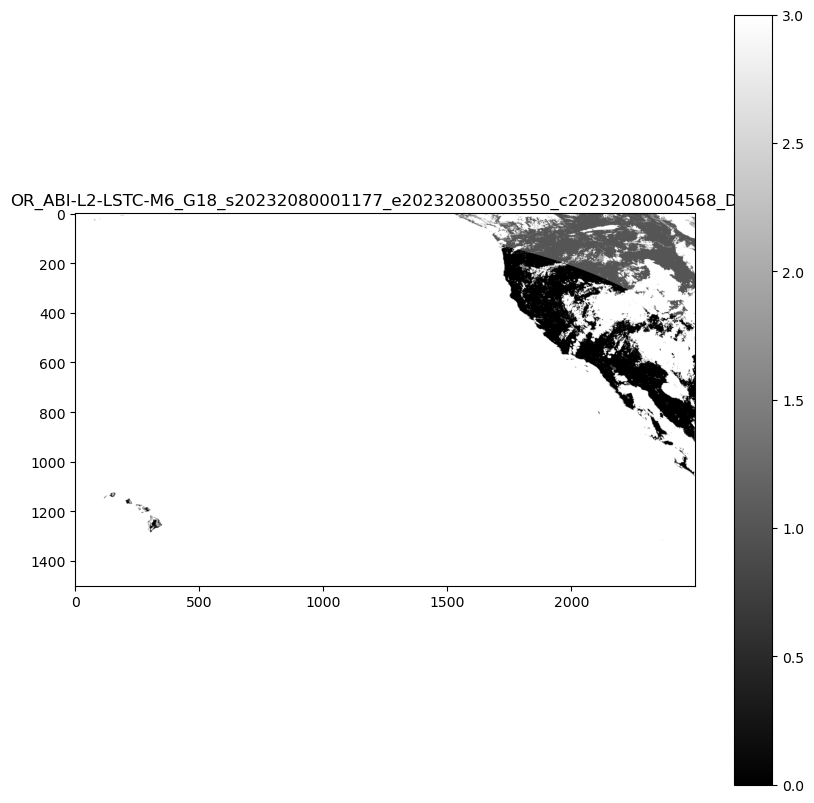

In [2]:
# Import Necessary Libraries 
import requests
from azure.storage.blob import ContainerClient
import matplotlib.pyplot as plt
from rasterio.io import MemoryFile
import os
from urllib.parse import urlparse

# Function to get the SAS token
def get_sas_token(endpoint):
    response = requests.get(endpoint)
    if response.status_code == 200:
        data = response.json()
        return data.get("token")
    else:
        raise Exception(f"Failed to get SAS token: {response.status_code} - {response.text}")

# Define Azure Blob Storage parameters
storage_account_name = "goeseuwest"
container_name = "noaa-goes-cogs"
blob_domain = f"https://{storage_account_name}.blob.core.windows.net"
sas_endpoint = f"https://planetarycomputer.microsoft.com/api/sas/v1/token/{storage_account_name}/{container_name}/"


# Get the SAS token
sas_token = get_sas_token(sas_endpoint)

# Construct the container URL with the SAS token
container_url = f"{blob_domain}/{container_name}?{sas_token}"

# Create a ContainerClient
container_client = ContainerClient.from_container_url(container_url)

# Define data you want, this can be changed for other datasets that are in storage in the open Planetary Computer
satellite = "goes-18"      # The specific GOES satellite (GOES-18, also known as GOES-West)
product = "ABI-L2-LSTC"    # The data product type (Advanced Baseline Imager Level 2 Land Surface Temperature - CONUS)
year = "2023"              # The year the data was collected
day_of_year = "208"        # The day of year (DOY) - day 208 corresponds to July 27, 2023

# Construct the directory path
directory_path = f"{satellite}/{product}/{year}/{day_of_year}/"

# Get just the first blob by using next() and limiting the iterator

first_blob = next(container_client.list_blobs(name_starts_with=directory_path))

# Function to read and display a .tif file from a URL
def display_tif_from_url(url, title):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with MemoryFile(response.content) as memfile:
            with memfile.open() as dataset:
                plt.figure(figsize=(10, 10))
                plt.imshow(dataset.read(1), cmap='gray')
                plt.title(title)
                plt.colorbar()
                plt.show()
    else:
        raise Exception(f"Failed to read .tif file: {response.status_code} - {response.text}")

# Create the URL for the blob using the container_url components
file_url = f"{blob_domain}/{container_name}/{first_blob.name}?{sas_token}"

# Extract the filename safely from the URL without the SAS token
parsed_url = urlparse(file_url)
path = parsed_url.path  # Gets just the path portion of the URL
filename = os.path.basename(path)  # Get just the filename part

# Remove .tif extension if present
file_name = filename.replace('.tif', '')

print(f"Extracted File Name: {file_name}")

display_tif_from_url(file_url, file_name)
    


From looking at the data and the file name, we can already see key pieces of metadata we'll need to build the STAC Item. The file name contains information about which satellite captured the data and when it was captured. 

For the sample, the file name is **OR_ABI-L2-LSTC-M6_G18_s20232080101177_e20232080103550_c20232080104570_DQF**, based on the product guide, this means:

### Detailed Components:

| Field | Description | Purpose |
|-------|-------------|---------|
| OR    | Operational system environment | Specifies the system environment in which the data was collected |
| ABI   | Advanced Baseline Imager instrument | Identifies the instrument used for capturing the data |
| L2    | Level 2 product (derived product) | Indicates that the data is a derived product, processed from raw observations |
| LSTC  | Land Surface Temperature (Clear Sky) product | Represents the specific product type, focusing on land surface temperature under clear sky conditions |
| M6    | Mode 6 scan (Full Disk scan) | Describes the scanning mode, covering the full disk of the Earth |
| G18   | GOES-18 satellite (also known as GOES-West) | Identifies the satellite from which the data was collected |

### Observation Time Details:

#### Start of Observation (s20232080201177)-

| Field           | Description | Purpose |
|-----------------|-------------|---------|
| Year            | 2023        | Specifies the year of the observation |
| Day of Year     | 208         | Indicates the day of the year when the observation started |
| Time            | 02:01:17 UTC| Provides the exact time the observation started in UTC |
| Tenths of Second| 7           | Adds precision to the start time of the observation |

#### End of Observation (e20232080203550)-

| Field           | Description | Purpose |
|-----------------|-------------|---------|
| Year            | 2023        | Specifies the year of the observation |
| Day of Year     | 208         | Indicates the day of the year when the observation ended |
| Time            | 02:03:55 UTC| Provides the exact time the observation ended in UTC |
| Tenths of Second| 0           | Adds precision to the end time of the observation |

#### File Creation Time (c20232080204563)-

| Field           | Description | Purpose |
|-----------------|-------------|---------|
| Year            | 2023        | Specifies the year the file was created |
| Day of Year     | 208         | Indicates the day of the year when the file was created |
| Time            | 02:04:56 UTC| Provides the exact time the file was created in UTC |
| Tenths of Second| 3           | Adds precision to the file creation time |

### Additional Information:

| Field | Description | Purpose |
|-------|-------------|---------|
| DQF   | Data Quality Flag, indicating quality information for the corresponding data | Provides information about the quality of the data |
| .tif  | File extension | Indicates the file format of the data |


The below code will extract this metadata from the file name using regular expressions (regex). 

In [3]:
import re
from datetime import datetime, timedelta

def extract_goes_metadata(filename):
    """
    Extracts key metadata from a NOAA GOES satellite filename using regular expressions.

    Args:
        filename (str): The filename to parse.

    Returns:
        dict: A dictionary containing the extracted metadata.
    """

    # Regular expression pattern to match the filename format
    pattern = re.compile(
        r"^(OR)_"  # System (OR)
        r"(ABI)-(L\d)-(LSTC)-(M\d)_"  # Instrument, Level, Product, Mode
        r"(G\d{2})_"  # Satellite (G18)
        r"s(\d{4})(\d{3})(\d{2})(\d{2})(\d{2})(\d)_"  # Start time
        r"e(\d{4})(\d{3})(\d{2})(\d{2})(\d{2})(\d)_"  # End time
        r"c(\d{4})(\d{3})(\d{2})(\d{2})(\d{2})(\d)_"  # Creation time
        r"([A-Z0-9]+)$"  # Data quality flag
    )

    match = pattern.match(filename)

    if not match:
        return None  # Or raise an exception if you prefer

    # Extract all fields from the regular expression match groups
    (
        system,          # Operational system environment
        instrument,      # Advanced Baseline Imager
        level,           # Product level (L2)
        product_type,    # Product type (LSTC - Land Surface Temperature)
        mode,            # Scanning mode (M6)
        satellite,       # Satellite identifier (G18)
        s_year, s_doy, s_hour, s_minute, s_second, s_tenth,  # Start time components
        e_year, e_doy, e_hour, e_minute, e_second, e_tenth,  # End time components
        c_year, c_doy, c_hour, c_minute, c_second, c_tenth,  # Creation time components
        data_quality_flag  # Quality flag indicator
    ) = match.groups()

    def parse_goes_time(year, doy, hour, minute, second, tenth):
        """Parses GOES time components into an ISO format string."""
        try:
            dt = datetime(int(year), 1, 1) + timedelta(
                days=int(doy) - 1,
                hours=int(hour),
                minutes=int(minute),
                seconds=int(second),
                microseconds=int(tenth) * 100000,
            )
            return dt
        except ValueError:
            return None

    # Parse the time components into datetime objects
    start_time = parse_goes_time(s_year, s_doy, s_hour, s_minute, s_second, s_tenth)
    end_time = parse_goes_time(e_year, e_doy, e_hour, e_minute, e_second, e_tenth)
    creation_time = parse_goes_time(c_year, c_doy, c_hour, c_minute, c_second, c_tenth)

    # Create a dictionary to organize all extracted metadata
    metadata = {
        "system": system,               # Operational system environment (e.g., "OR" for operational)
        "instrument": instrument,       # Instrument used to capture data (e.g., "ABI" for Advanced Baseline Imager)
        "level": level,                 # Processing level of the data (e.g., "L2" for Level 2)
        "product_type": product_type,   # Type of product (e.g., "LSTC" for Land Surface Temperature Clear Sky)
        "mode": mode,                   # Scanning mode (e.g., "M6" for Mode 6, full disk scan)
        "satellite": satellite,         # Satellite identifier (e.g., "G18" for GOES-18)
        "start_time": start_time,       # Observation start time as datetime object
        "end_time": end_time,           # Observation end time as datetime object
        "creation_time": creation_time, # File creation time as datetime object
        "data_quality_flag": data_quality_flag,  # Quality flag for the data (e.g., "DQF")
    }

    return metadata


# Example usage:
print(file_name)
metadata_from_filename = extract_goes_metadata(file_name)
print(metadata_from_filename)

OR_ABI-L2-LSTC-M6_G18_s20232080001177_e20232080003550_c20232080004568_DQF
{'system': 'OR', 'instrument': 'ABI', 'level': 'L2', 'product_type': 'LSTC', 'mode': 'M6', 'satellite': 'G18', 'start_time': datetime.datetime(2023, 7, 27, 0, 1, 17, 700000), 'end_time': datetime.datetime(2023, 7, 27, 0, 3, 55), 'creation_time': datetime.datetime(2023, 7, 27, 0, 4, 56, 800000), 'data_quality_flag': 'DQF'}


### Creating STAC Items from Cloud-Optimized GeoTIFF Files

The next block of code leverages the `rio-stac` library to automate the creation of STAC Items from Cloud-Optimized GeoTIFFs (COGs).

When pointed to a COG file, `rio-stac` automatically extracts and organizes essential metadata like spatial bounds, projection information, and raster properties into a standardized STAC format. The library handles the complex task of reading the embedded technical metadata from the GeoTIFF and converts it into STAC-compliant fields, including:

- **Geometry**
- **Bounding Box (bbox)**
- **Projection Details**
- **Raster Characteristics**
- **STAC Extensions**

This automation significantly reduces the manual work needed to create valid STAC Items and ensures consistency in metadata 

In [4]:
from rio_stac import create_stac_item
from rasterio.io import MemoryFile
import json
from urllib.parse import urlparse, unquote

def create_stac_item_from_cog(url):
    """
    Create a basic STAC Item for GOES data using rio-stac with proper spatial handling
    
    Args:
        url (str): URL to the COG file
        
    Returns:
        pystac.Item: STAC Item with basic metadata and correct spatial information
    """
    
    # Extract the filename safely from the URL
    parsed_url = urlparse(url)
    path = parsed_url.path  # Gets just the path portion of the URL
    filename = os.path.basename(path)  # Get just the filename part
    
    # Remove .tif extension if present
    item_id = filename.replace('.tif', '')
    
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with MemoryFile(response.content) as memfile:
            with memfile.open() as dataset:
                # Create base STAC item from rasterio dataset calling create_stac_item from rio_stac
                stac_item = create_stac_item(
                    source=dataset,  # The rasterio dataset object representing the COG file
                    id=item_id,  # Generate a unique ID by extracting the filename without the .tif extension
                    asset_name='data',  # Name of the asset, indicating it contains the primary data
                    asset_href=url,  # URL to the COG file, used as the asset's location
                    with_proj=True,  # Include projection metadata (e.g., CRS, bounding box, etc.)
                    with_raster=True,  # Include raster-specific metadata (e.g., bands, resolution, etc.)
                    properties={
                        'datetime': None,  # Set datetime to None since explicit start/end times may be added later
                        # Add rasterio-specific metadata for the raster bands
                        'raster:bands': [
                            {
                                'nodata': dataset.nodata,  # Value representing no data in the raster
                                'data_type': dataset.dtypes[0],  # Data type of the raster (e.g., uint16)
                                'spatial_resolution': dataset.res[0]  # Spatial resolution of the raster in meters
                            }
                        ],
                        'file:size': len(response.content)  # Size of the file in bytes
                    },
                    extensions=[
                        'https://stac-extensions.github.io/file/v2.1.0/schema.json'  # Add the file extension schema for additional metadata
                    ]
                )
                
                return stac_item
    else:
        raise Exception(f"Failed to read .tif file: {response.status_code} - {response.text}")

# Example usage
sas_token = get_sas_token(sas_endpoint) # refresh the SAS token prior to creating STAC item
# Create file URL using the first_blob variable that's already defined
file_url = f"{blob_domain}/{container_name}/{first_blob.name}?{sas_token}"
# Create STAC item for the first blob
stac_item = create_stac_item_from_cog(file_url)

# Print the STAC item as JSON
print(json.dumps(stac_item.to_dict(), indent=2))

{
  "type": "Feature",
  "stac_version": "1.0.0",
  "stac_extensions": [
    "https://stac-extensions.github.io/file/v2.1.0/schema.json",
    "https://stac-extensions.github.io/projection/v1.1.0/schema.json",
    "https://stac-extensions.github.io/raster/v1.1.0/schema.json"
  ],
  "id": "OR_ABI-L2-LSTC-M6_G18_s20232080001177_e20232080003550_c20232080004568_DQF",
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          -161.57885623466754,
          14.795666555826678
        ],
        [
          -112.42114380921453,
          14.79566655500485
        ],
        [
          -89.5501123912648,
          53.52729778421186
        ],
        [
          175.5501122574517,
          53.52729779865781
        ],
        [
          -161.57885623466754,
          14.795666555826678
        ]
      ]
    ]
  },
  "bbox": [
    -161.57885623466754,
    14.79566655500485,
    175.5501122574517,
    53.52729779865781
  ],
  "properties": {
    "datetime": "2025-0


## Explaining the STAC Item JSON from rio-stac

The rio-stac library was able to read the GOES COG file and extract key metadata automatically. 

In addition, based on the type of metadata included, it also added the relevent [STAC Extensions](https://stac-extensions.github.io). STAC Extensions enhance the core specification by adding standardized, domain-specific metadata. 

- [File Extension](https://stac-extensions.github.io/file/v2.1.0/schema.json) provides essential file metadata like size and checksums.
- [Projection Extension](https://stac-extensions.github.io/projection/v1.1.0/schema.json) captures spatial reference information including coordinate systems and bounding boxes.
- [Raster Extension](https://stac-extensions.github.io/raster/v1.1.0/schema.json) standardizes properties specific to raster data, such as band information and spatial resolution. 

Below is an explanation of all the metadata it found. 

### Core Fields

| Field            | Description              | Purpose                                         |
|------------------|--------------------------|-------------------------------------------------|
| type             | Always "Feature"         | Identifies this as a GeoJSON Feature            |
| stac_version     | "1.0.0"                  | Specifies STAC standard version                 |
| id               | Unique identifier        | Contains satellite, product, and time information|
| stac_extensions  | List of schema URLs      | Defines additional metadata fields              |

### Spatial Information

| Field            | Description              | Purpose                                         |
|------------------|--------------------------|-------------------------------------------------|
| geometry         | GeoJSON polygon          | Defines the data footprint in WGS84 coordinates |
| bbox             | Bounding box coordinates | Provides simple spatial extent for quick filtering|
| proj:geometry    | Projection-specific polygon | Footprint in native projection coordinates     |
| proj:bbox        | Native projection bounds | Spatial extent in satellite's coordinate system |
| proj:shape       | [1500, 2500]             | Image dimensions in pixels                      |
| proj:transform   | Affine transformation    | Maps pixel to coordinate space                  |
| proj:wkt2        | Well-Known Text          | Complete projection definition                  |
| proj:epsg        | null                     | No standard EPSG code exists for this projection|

### Temporal Information

| Field            | Description              | Purpose                                         |
|------------------|--------------------------|-------------------------------------------------|
| datetime         | Creation timestamp       | When this STAC item was created                 |

### Raster Information

| Field            | Description              | Purpose                                         |
|------------------|--------------------------|-------------------------------------------------|
| raster:bands     | Array of band objects    | Describes raster data properties                |
| → data_type      | "uint16"                 | Pixel data type                                 |
| → spatial_resolution | 2004.02m             | Ground sample distance                          |
| → scale/offset   | Conversion factors       | Transforms pixel values to physical units (Kelvin)|
| → nodata         | 65535.0                  | Value representing no data                      |
| → statistics     | Statistical summary      | Provides data distribution information          |
| → histogram      | Value distribution       | Visualizes data distribution                    |

### Asset Information

| Field            | Description              | Purpose                                         |
|------------------|--------------------------|-------------------------------------------------|
| assets.data      | Main data asset          | Points to the actual data file                  |
| → href           | URL                      | Location of the Cloud-Optimized GeoTIFF         |
| → type           | Media type               | Identifies file format                          |

### File Metadata

| Field            | Description              | Purpose                                         |
|------------------|--------------------------|-------------------------------------------------|
| file:size        | 943250 bytes             | Size of the data file                           |


## Adding the metadata from the File Name

Next, we'll add the data we found in the file name to complete filling out the metadata for this STAC Item. 

One thing to note is all the datetime's for STAC Items must conform to [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601). The PySTAC library has a datetime_to_str function which ensures the data is formatted correctly. 

In [5]:
import pystac

def enhance_stac_item_with_metadata(stac_item, metadata_from_filename):
    """
    Enhances a STAC Item with additional metadata from GOES filename.
    
    Args:
        stac_item (pystac.Item): Existing STAC Item created by rio-stac
        metadata_from_filename (dict): Metadata extracted from filename
        
    Returns:
        pystac.Item: Enhanced STAC Item
    """
    # Add satellite/sensor properties to the STAC item
    stac_item.properties.update({
        'platform': f"GOES-{metadata_from_filename['satellite'][1:]}",
        'instruments': [metadata_from_filename['instrument']],
        'constellation': 'GOES'
    })
    
    # Add temporal properties to the STAC item, use pystac to ensure time conforms to ISO 8601
    stac_item.datetime = None  # Clear the default datetime
    stac_item.properties.update({
        'start_datetime': pystac.utils.datetime_to_str(metadata_from_filename['start_time']),
        'end_datetime': pystac.utils.datetime_to_str(metadata_from_filename['end_time']),
        'created': pystac.utils.datetime_to_str(metadata_from_filename['creation_time'])
    })
    
    # Add GOES-specific properties to the STAC item
    stac_item.properties.update({
        'goes:system': metadata_from_filename['system'],
        'goes:level': metadata_from_filename['level'],
        'goes:product_type': metadata_from_filename['product_type'],
        'goes:mode': metadata_from_filename['mode'],
        'goes:processing_level': metadata_from_filename['level'],
        'goes:data_quality_flag': metadata_from_filename['data_quality_flag']
    })
    
    return stac_item


# Example usage in new cell
stac_item = enhance_stac_item_with_metadata(stac_item, metadata_from_filename)
print(json.dumps(stac_item.to_dict(), indent=2))

{
  "type": "Feature",
  "stac_version": "1.0.0",
  "stac_extensions": [
    "https://stac-extensions.github.io/file/v2.1.0/schema.json",
    "https://stac-extensions.github.io/projection/v1.1.0/schema.json",
    "https://stac-extensions.github.io/raster/v1.1.0/schema.json"
  ],
  "id": "OR_ABI-L2-LSTC-M6_G18_s20232080001177_e20232080003550_c20232080004568_DQF",
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          -161.57885623466754,
          14.795666555826678
        ],
        [
          -112.42114380921453,
          14.79566655500485
        ],
        [
          -89.5501123912648,
          53.52729778421186
        ],
        [
          175.5501122574517,
          53.52729779865781
        ],
        [
          -161.57885623466754,
          14.795666555826678
        ]
      ]
    ]
  },
  "bbox": [
    -161.57885623466754,
    14.79566655500485,
    175.5501122574517,
    53.52729779865781
  ],
  "properties": {
    "datetime": null,
 

## Adding the STAC Item to a Collection

Microsoft Planetary Computer Pro requires all STAC Items have a reference to the parent STAC Collection ID they will be ingested into. For this tutorial, the STAC Collection ID will be the name of the satellite and the data product.

Using PySTAC, it is easy to use some of the metadata we've already collected to populate the key fields for the STAC Collection and use the built-in validation functions. 

The below code will create a parent STAC Collection to house the GOES data, and then output all of this into files we will use to create collection and ingest items into MPC Pro. 

In [108]:
# Define collection properties
collection_id = f"{satellite}-{product}"
collection_title = f"{satellite.upper()} {product} Collection" 
collection_desc = f"Collection of {satellite} {product} Earth observation data"

# Create spatial extent
bbox = [-180, -60, 10, 60]  # this is a placeholder, replace with actual data at a later date
spatial_extent = pystac.SpatialExtent([bbox])

# Create temporal extent, use current date time or replace with existing datetimes in stac_item
start_datetime = datetime.now()
if hasattr(metadata_from_filename, 'get'): 
    if metadata_from_filename.get('start_time'):
        start_datetime = metadata_from_filename.get('start_time')

temporal_extent = pystac.TemporalExtent([[start_datetime, None]])
extent = pystac.Extent(spatial=spatial_extent, temporal=temporal_extent)

# Create the STAC Collection
collection = pystac.Collection(
    id=collection_id,
    description=collection_desc,
    extent=extent,
    title=collection_title,
    license="public-domain",
)

# Add keywords and provider
collection.keywords = ["GOES", "satellite", "weather", "NOAA", satellite, product]
collection.providers = [
    pystac.Provider(
        name="NOAA",
        roles=["producer", "licensor"],
        url="https://www.noaa.gov/"
    )
]

# Create output directories
output_dir = "stac_catalog"
collection_dir = os.path.join(output_dir, collection_id)
items_dir = os.path.join(collection_dir, "items")
os.makedirs(items_dir, exist_ok=True)

# Important: Save the collection first to generate proper file paths
collection_path = os.path.join(collection_dir, "collection.json")
collection.set_self_href(collection_path)

# Extract filename for the item
original_filename = first_blob.name.split('/')[-1]
base_filename = original_filename.replace('.tif', '')
item_path = os.path.join(items_dir, f"{base_filename}.json")

# Set the item's proper href
stac_item.set_self_href(item_path)

# Now associate the item with the collection (after setting hrefs)
collection.add_item(stac_item)

# Create a catalog to contain the collection
catalog = pystac.Catalog(
    id="goes-data-catalog",
    description="GOES Satellite Data Catalog",
    title="GOES Data"
)
catalog_path = os.path.join(output_dir, "catalog.json")
catalog.set_self_href(catalog_path)
catalog.add_child(collection)

# Validate the collection and contained items
print("Validating collection and items...")
try:
    collection.validate_all()
    print("✅ Collection and items validated successfully")
    
    # Save everything to disk
    catalog.normalize_and_save(catalog_path, pystac.CatalogType.SELF_CONTAINED)
    print(f"✅ STAC catalog saved at: {catalog_path}")
    print(f"✅ STAC collection saved at: {collection_path}")
    print(f"✅ STAC item saved at: {item_path}")
    
except Exception as e:
    print(f"❌ Validation error: {str(e)}")

Validating collection and items...
✅ Collection and items validated successfully
✅ STAC catalog saved at: stac_catalog/catalog.json
✅ STAC collection saved at: stac_catalog/goes-18-ABI-L2-LSTC/collection.json
✅ STAC item saved at: stac_catalog/goes-18-ABI-L2-LSTC/items/OR_ABI-L2-LSTC-M6_G18_s20232080001177_e20232080003550_c20232080004568_DQF.json


## Adding your new STAC Items to Microsoft Planetary Computer Pro

Now that we have a STAC Collection and STAC Item created, we can use add this data to the Microsoft Planeteary Computer Pro. 

- To add the entire catalog, follow the [Bulk Ingestion Quickstart](bulk-ingestion-api.md)

- To add a single item, follow the [Add STAC Items to a Collection](items-api-python.md)

We also offer the [STAC Forge tool](/tools/stacforge-functions/README.md) which provides increased automation using templates around data. 
